# Packages

In [49]:
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from ipywidgets import HTML
import ipywidgets as widgets
from ipyleaflet import Map, Polyline, Rectangle, basemaps, basemap_to_tiles, Polygon, FullScreenControl, Popup, WidgetControl

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np

import os

import sys
sys.path.append('/datc/saab/notebooks')

Using GPU 4

In [50]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# Define some functions

In [51]:
def rgb_to_hex(rgb):
    if len(rgb) == 4:
        rgb = rgb[:3]
    return '#%02x%02x%02x' % tuple(list([int(elem*256) for elem in rgb]))
def random_hex_color():
    import random
    r = lambda: random.randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))

# Import Dataset

In [74]:
from saab import datasets
data = datasets.reduced_area()

In [75]:
ID_df = data[['mmsi']].values

# Scale the data
Here we had to take apart the mmsi in order not to loose the Identification method we are using for each ship as the mmsi is not going to be used to train

In [76]:
x = data[['latitude', 'longitude']].values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = np.array([np.append(ID_df[i],x_scaled[i]) for i in range(len(ID_df))])

# Define the timesteps in total to examine
Given time_steps = 5 means that we will train on 4 and try to predict the 5th move

In [55]:
time_steps = 20

# Convert to Dataframe

In [56]:
data = pd.DataFrame(x_scaled, columns = ['mmsi', 'latitude','longitude','orientation', 'speed'])
data.head()

,mmsi,latitude,longitude,orientation,speed
0,56295.0,-0.604076,-1.448167,-0.864319,-0.795048
1,56946.0,-1.546037,-1.480834,1.272607,0.548078
2,54494.0,1.533019,-1.176046,-1.261125,1.283635
3,0.0,-0.084565,-1.196246,-0.214674,0.150878
4,0.0,-0.863608,-1.209587,0.822853,-0.969825


# Get the ship's sequences of points

In [57]:
CRAFT_ID_list = data.mmsi.unique()#Get the mmsi unique values into a list:
CRAFT_ID_list = CRAFT_ID_list[CRAFT_ID_list!=0]

In [58]:
ships_info = [[] for j in range(len(CRAFT_ID_list))]#List that will storage a list of lists == a list of time-series(which will as well be represented as a list)

for i, rowid in enumerate(CRAFT_ID_list):
    #Start with empty lists
    npinfo = []
    #Get a numpy array composed by 'latitude', 'longitude', 'orientation', 'length', 'breadth'
    npinfo = data[data.mmsi == rowid][['latitude', 'longitude']].values
    #Convert it to a python list so it can be an attribute of the multypoligon functionality of ipyleaflet
    ships_info[i]=npinfo

# Check out what the input sizes are

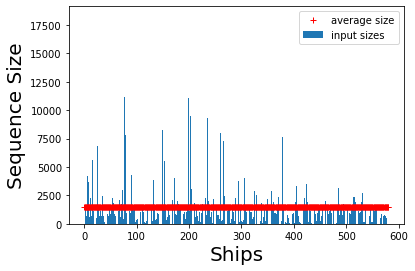

In [59]:
input_sizes = [len(ship) for ship in ships_info]
# Make a fake dataset:
x_pos = np.arange(len(input_sizes))
 
# Create bars
plt.bar(x_pos, input_sizes)
plt.plot(x_pos, [sum(input_sizes)/len(input_sizes)]*len(x_pos), 'r+')
plt.xlabel('Ships', fontsize=20)
plt.ylabel('Sequence Size', fontsize=20)
plt.legend(['average size', 'input sizes'])
# Show graphic
plt.show()

# Extract the sequences of size _time steps_ from the entire sequences

In [60]:
input_data = []
output_data = []

for ship in ships_info:
    for i in range(len(ship)//time_steps):
        input_data.append(ship[time_steps*i:time_steps*i+time_steps-1])
        output_data.append(ship[time_steps*i+time_steps-1])

Check the shapes of the training and test sets

In [61]:
X_train, X_test, y_train, y_test = train_test_split(np.array(input_data), np.array(output_data), test_size=0.3)
print(X_train.shape, y_train.shape)

(30427, 19, 2) (30427, 2)


# Define the model

In [67]:
model = Sequential()
model.add(LSTM(150, activation='sigmoid', input_shape=(time_steps-1,2)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(X_train, y_train,
          batch_size=150, epochs=200,
          validation_data=(X_test, y_test))

Train on 30427 samples, validate on 13041 samples
Epoch 1/200
30427/30427 [==============================] - 7s 239us/step - loss: 0.1875 - mean_squared_error: 0.1875 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/200
30427/30427 [==============================] - 7s 216us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/200
30427/30427 [==============================] - 7s 220us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 4/200
30427/30427 [==============================] - 7s 218us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/200
30427/30427 [==============================] - 7s 218us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 6/200
30427/30427 [==============================] - 7s 219us/step - loss: 0.0031 - mean_squared_er

Epoch 49/200
30427/30427 [==============================] - 7s 220us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 50/200
30427/30427 [==============================] - 7s 217us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 51/200
30427/30427 [==============================] - 6s 207us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 52/200
30427/30427 [==============================] - 6s 210us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 53/200
30427/30427 [==============================] - 6s 212us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 54/200
30427/30427 [==============================] - 6s 212us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0019 - val_mean_sq

30427/30427 [==============================] - 6s 210us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 98/200
30427/30427 [==============================] - 7s 215us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 99/200
30427/30427 [==============================] - 7s 215us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 100/200
30427/30427 [==============================] - 7s 220us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 101/200
30427/30427 [==============================] - 7s 219us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 102/200
30427/30427 [==============================] - 7s 219us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_erro

30427/30427 [==============================] - 7s 218us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 146/200
30427/30427 [==============================] - 6s 197us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 147/200
30427/30427 [==============================] - 6s 204us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 148/200
30427/30427 [==============================] - 7s 223us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 149/200
30427/30427 [==============================] - 6s 191us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 150/200
30427/30427 [==============================] - 6s 201us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_er

Epoch 193/200
30427/30427 [==============================] - 7s 219us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 194/200
30427/30427 [==============================] - 7s 222us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 195/200
30427/30427 [==============================] - 7s 221us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 196/200
30427/30427 [==============================] - 7s 220us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 197/200
30427/30427 [==============================] - 7s 220us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 198/200
30427/30427 [==============================] - 7s 219us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0016 - val_m

Summary of the model architecture

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 150)               91800     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 302       
Total params: 92,102
Trainable params: 92,102
Non-trainable params: 0
_________________________________________________________________


# Evaluation Graphs
This trining has ben set with 200 epochs just to show how it evolves (Portfolio).
As the training curve lows down, the test one tends to  to get stationary.
The order of magnitude, taking into account that we are dealing with LAT, LON data is still not assumable

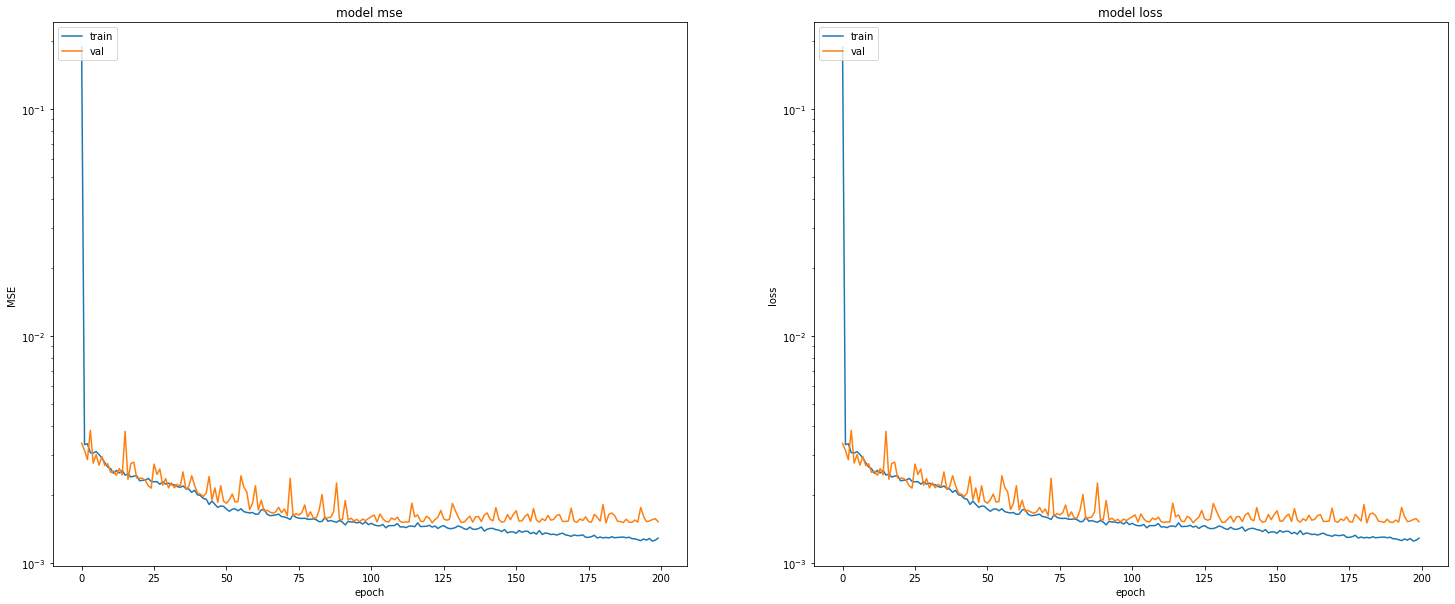

In [71]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('MSE')
plt.yscale('log')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Visual Evaluation

In [77]:
y_pred = model.predict(X_test, batch_size = 150)

In [78]:
Y_pred = min_max_scaler.inverse_transform(y_pred)

In [79]:
Y_pred

array([[-25.451502, -43.74217 ],
       [-25.460869, -43.769547],
       [-25.475126, -43.709072],
       ...,
       [-25.494198, -43.706932],
       [-25.528194, -43.743385],
       [-25.47174 , -43.744484]], dtype=float32)

# Predictions vs Reality

Text(0.5, 0, 'Actual Next Step')

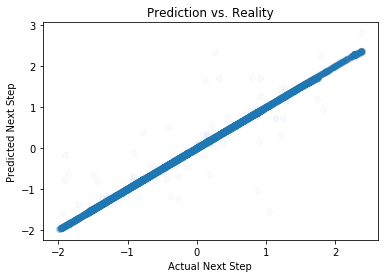

In [88]:
plt.scatter(y_test,y_pred,alpha=0.025)
plt.title('Prediction vs. Reality')
plt.ylabel('Predicted Next Step')
plt.xlabel('Actual Next Step')

In [81]:
X_test_unscaled = [min_max_scaler.inverse_transform(elem) for elem in X_test]

In [82]:
y_test_unscaled = min_max_scaler.inverse_transform(y_test)

In [83]:
y_test_unscaled

array([[-25.45153028, -43.74231949],
       [-25.46056128, -43.76990081],
       [-25.47509894, -43.70959184],
       ...,
       [-25.49399439, -43.70745194],
       [-25.52812386, -43.74351609],
       [-25.47161814, -43.74479743]])

In [92]:
[np.linalg.norm(elem) for elem in abs(Y_pred-y_test_unscaled)]

[0.00015371473178004105,
 0.0004691684465412389,
 0.0005204487689235772,
 0.0004023744417506508,
 0.00017285861474447285,
 0.00014632090528258638,
 0.0005459403690204141,
 0.00023576555291956027,
 0.00032260286317112937,
 0.0007047946825669689,
 0.0001620021485209708,
 0.00017003869066495466,
 0.00023169082239271,
 0.0004333748909586978,
 0.00043189052919543133,
 0.00019354331875283607,
 0.00019358694762093714,
 0.00032686549397329924,
 0.0001494999184267799,
 0.0004685410933480313,
 0.0003190323597636727,
 0.0006508925812992794,
 0.00019687308627089307,
 0.00020538124321533343,
 0.00017611241950772486,
 0.0003206886594711061,
 0.00012297243125095774,
 0.00026011720035772746,
 0.00046772804753936393,
 0.0005601268482131285,
 0.00036717155636163765,
 0.000604876243008085,
 8.571564933350004e-05,
 0.00047458681323915016,
 0.0001483655734544538,
 0.00010165894217415436,
 8.54722132447416e-05,
 0.00013091053538649618,
 7.953944088142228e-05,
 0.00021900156747989969,
 0.00014863105015495108

# Unscaled Predictions vs Reality

Text(0.5, 0, 'Actual Next Step')

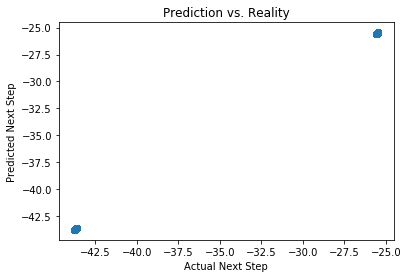

In [89]:
plt.scatter(y_test_unscaled,Y_pred,alpha=0.025)
plt.title('Prediction vs. Reality')
plt.ylabel('Predicted Next Step')
plt.xlabel('Actual Next Step')

# Map Visualization

In [86]:
m = Map(center = (-25.353548853000003, -43.935133436), zoom =4)#Define the map object

#To define  the maximum number of steps we will be able to take with the slider
max_steps = max([len(element) for element in ships_info])
ships_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(X_test),
    step=1,
    description='Ships: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
widget_steps = WidgetControl(widget=ships_slider, position='topright')
m.add_control(widget_steps)
m.add_control(FullScreenControl())
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
m.add_layer(dark_matter_layer)
previous_value = 0


def update_map(ships_slider):
    global previous_value, m
    if previous_value > ships_slider:
        m = Map(center = (-22.884059, 133.714373), zoom =4)#Define the map object
        ini, end = 0, ships_slider
    else:
        ini, end = previous_value, ships_slider
        
    for i in range(ini, end):
        color_value = random_hex_color()
        #for each time series in ships_info list --> Paint The line
        
        pred_line = Polyline(
            #last unscaled Location value ---> Predicted next values
            locations = [[X_test_unscaled[i][-1][0], X_test_unscaled[i][-1][1]], [Y_pred[i][0], Y_pred[i][1]]],
            color = color_value,
            fill_color= "transparent",
            weight = 3,
            opacity = 1)
        m.add_layer(pred_line)
        #print('Plotted the following predicted sequence:', [[X_test_unscaled[i][-1][0], X_test_unscaled[i][-1][1]], [Y_pred[i][0], Y_pred[i][1]]])
        
        real_line = Polyline(
            #Unscaled values  ----> Unscaled target value
            locations = [[elem[0],elem[1]] for elem in X_test_unscaled[i]] + [[y_test_unscaled[i][0], y_test_unscaled[i][1]]],
            color = color_value,
            fill_color= "transparent",
            weight = 10,
            opacity = 0.7)
        
        m.add_layer(real_line)
        
        real_line1 = Polyline(
        locations = [[elem[0],elem[1]] for elem in X_test_unscaled[i]],
        color = color_value,
        fill_color= "transparent",
        weight = 10,
        opacity = 0.7)
        
        m.add_layer(real_line1)
    previous_value = ships_slider
    display(m)
widgets.interactive(update_map, ships_slider=ships_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Ships: ', max=13041), Output())…